In [1]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(gridExtra)
library(stringr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

The data we have chosen are the statistics of the top 500 players, which gives the statistics of the top 500 tennis players. By using this dataset, we can predict how the age of tennis players and the prize money received will affect their ranking.

In [2]:
#using the read_csv function to load data from web
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
set.seed(999)
#select the variables we want to use and check how many NA rows there are in each column.
tennis_data <- tennis |>
  select(Age, 'Prize Money', 'Current Rank') |>
map_df(~sum(is.na(.)))
names(tennis_data) <- c("Age", "Prize", "Current_rank")
tennis_data

Age,Prize,Current_rank
<int>,<int>,<int>
1,81,5


In [4]:
set.seed(999)
#check the values of each column
tennis_data <- tennis |>
select(Age, 'Prize Money', 'Current Rank') 
names(tennis_data) <- c("Age", "Prize", "Current_rank")
tennis_data <- tennis_data |>
  select(Age, Prize, Current_rank)
head(tennis_data)

Age,Prize,Current_rank
<chr>,<chr>,<chr>
26 (25-04-1993),NA,378 (97)
18 (22-12-2001),"$59,040",326 (119)
32 (03-11-1987),"US$3,261,567",178 (280)
21 (29-05-1998),"$374,093",236 (199)
27 (21-10-1992),"US$6,091,971",183 (273)
22 (11-02-1997),"$1,517,157",31 (1398)


In [5]:
set.seed(999)
#Removing special symbols from each column and filter out any rows that contain NA values for the selected columns
tennis_data <- tennis_data |>
select(Age, Prize, Current_rank) %>%
mutate(across(Age: Current_rank, function(col) {str_extract(col, "^[^ ]+")}))|>
mutate(Prize = as.numeric(gsub("[^0-9.]+", "", Prize)))|>
                mutate(Age = as.numeric(Age))|>
                mutate(Current_rank = as.numeric(Current_rank))|>
  filter(!is.na(Prize) & !is.na(Age) & !is.na(Current_rank)) |>
  filter(Prize <= 100000000) |>
  mutate(rank_top_150 = ifelse(Current_rank <= 150, "top 150", "not top 150")) |> # convert chr to fct
  mutate(rank_top_150 = as.factor(rank_top_150)) |>
  select(Age, Prize, rank_top_150)#select only the columns we need

head(tennis_data)

Age,Prize,rank_top_150
<dbl>,<dbl>,<fct>
18,59040,not top 150
32,3261567,not top 150
21,374093,not top 150
27,6091971,not top 150
22,1517157,top 150
28,278709,not top 150


Then, we first use the initial_split function to separate the data to training and test sets. We specify that prop = 0.75 so that 75% of our original data set ends up in the training set. We can see from glimpse in the code that the training set contains 293 rows, while the test set contains 99 rows, which corresponds to the split of 75% / 25%.

In [6]:
set.seed(999)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = rank_top_150)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)
glimpse(tennis_train)
glimpse(tennis_test)

Rows: 293
Columns: 3
$ Age          <dbl> 18, 32, 21, 27, 28, 21, 30, 30, 26, 24, 21, 28, 20, 22, 2…
$ Prize        <dbl> 59040, 3261567, 374093, 6091971, 278709, 59123, 184328, 1…
$ rank_top_150 <fct> not top 150, not top 150, not top 150, not top 150, not t…
Rows: 99
Columns: 3
$ Age          <dbl> 22, 25, 20, 28, 23, 30, 22, 30, 22, 28, 26, 34, 27, 22, 3…
$ Prize        <dbl> 1517157, 122734, 74927, 303458, 54004, 898701, 87942, 631…
$ rank_top_150 <fct> top 150, not top 150, top 150, top 150, not top 150, top …


The table below shows the percentage of top 150 and non-top 150 tennis players, and it can be seen that after we filter out the rows containing NA values, the number of top 500 players is left at 293, with 98 top 150 players and 195 non-top 150 players. In terms of percentage, about 1/3 of tennis players are top 150 and 2/3 of tennis players are not top 150.

In [10]:
set.seed(999)
tennis_proportions <- tennis_train |>
                      group_by(rank_top_150) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(tennis_train))

tennis_proportions

rank_top_150,n,percent
<fct>,<int>,<dbl>
not top 150,195,66.5529
top 150,98,33.4471


The mean and standard deviation of Age and Prize money were calculated for top_150 and not_top_150 using the summarize function. Based on the results, the average age of top 150 tennis players is 1.2 years older than that of non-top 150 tennis players, and the average current ranking of top 150 tennis players is about 4.78 times that of non-top 150 tennis players. In addition, the standard deviation of the age of the top 150 tennis players was 0.2 lower than that of the non-top 150 tennis players, and the standard deviation of the current ranking of the top 150 tennis players was approximately 2.84 times higher than that of the non-top 150 tennis players.

In [7]:
set.seed(999)
tennis_summary_avg <- tennis_train %>%
  group_by(rank_top_150) %>%
  summarize(
    avg_age = mean(Age),
    avg_current_rank = mean(Prize)
  )

tennis_summary_avg

tennis_summary_sd <- tennis_train %>%
  group_by(rank_top_150) %>%
  summarize(
    sd_age = sd(Age),
    sd_current_rank = sd(Prize)
  )

tennis_summary_sd

rank_top_150,avg_age,avg_current_rank
<fct>,<dbl>,<dbl>
not top 150,25.75897,886894.7
top 150,26.91837,4240960.7


rank_top_150,sd_age,sd_current_rank
<fct>,<dbl>,<dbl>
not top 150,4.475403,1925523
top 150,4.202781,5466542


The scatter plot below shows the correlation between the age of the top 150 ranked tennis players and their prize money on the x and y axes. According to the plot, most of the signal shows that the older the player are, the higher the likelihood of getting a higher prize.

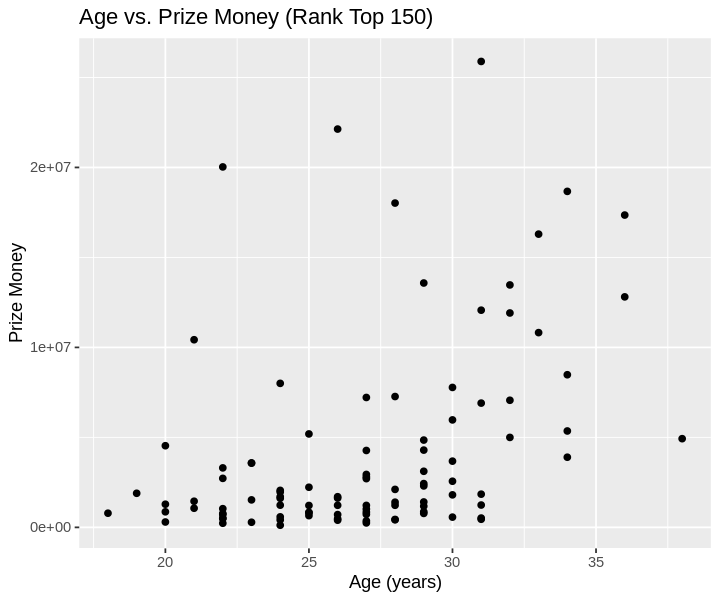

In [27]:
set.seed(999)
top_150_plot <- ggplot(data = filter(tennis_train, rank_top_150 == "top 150"),
                    aes(x = Age, y = Prize)) +
  geom_point() +
  labs(title = "Age vs. Prize Money (Rank Top 150)",
       x = "Age (years)",
       y = "Prize Money")
top_150_plot

The scatter plot below shows the correlation between the age of the non-top 150 ranked tennis players and their prize money on the x and y axes. Like the previous plot, as age increases, the higher the prize money received, but this plot for players not ranked in the top 150 shows a clearer trend than the plot for the top 150 players. 

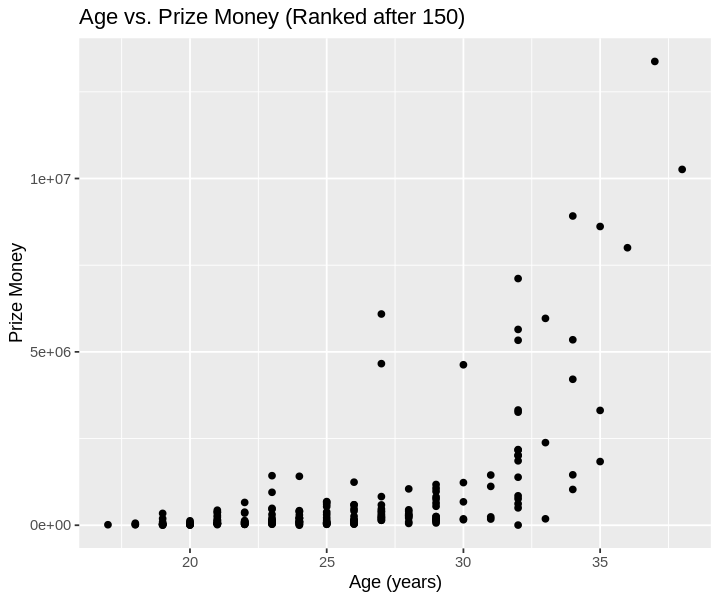

In [32]:
set.seed(999)
not_top_150_plot <- ggplot(data = filter(tennis_train, rank_top_150 == "not top 150"),
                    aes(x = Age, y = Prize)) +
  geom_point() +
  labs(title = "Age vs. Prize Money (Ranked after 150)",
       x = "Age (years)",
       y = "Prize Money")
not_top_150_plot

The k-nearest neighbors（knn) algorithm is used to find the optimal set of hyperparameters. The performance of the model is evaluated using 10-fold cross-validation. The accuracy is used to assess the performance of our model. 

In [33]:
set.seed(999) 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

tennis_recipe <- recipe(rank_top_150 ~., data = tennis_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = rank_top_150)

knn_results <- workflow() |>
                 add_recipe(tennis_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = tennis_vfold, grid = 10) |>
                 collect_metrics()

accuracy <- knn_results |>
                 filter(.metric == 'accuracy')
accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7484072,10,0.02508895,Preprocessor1_Model1
4,accuracy,binary,0.7922167,10,0.01342258,Preprocessor1_Model2
5,accuracy,binary,0.7958867,10,0.02192485,Preprocessor1_Model3
6,accuracy,binary,0.7958867,10,0.02192485,Preprocessor1_Model4
7,accuracy,binary,0.8026847,10,0.02005309,Preprocessor1_Model5
9,accuracy,binary,0.7921018,10,0.01764384,Preprocessor1_Model6
10,accuracy,binary,0.7921018,10,0.01764384,Preprocessor1_Model7
12,accuracy,binary,0.8093514,10,0.01915169,Preprocessor1_Model8
14,accuracy,binary,0.8093514,10,0.01895997,Preprocessor1_Model9


We can determine the best value of k to enhance the accuracy of the model by examining the connection between k and accuracy. This data can be employed to increase the model's efficiency and generate more precise forecasts.

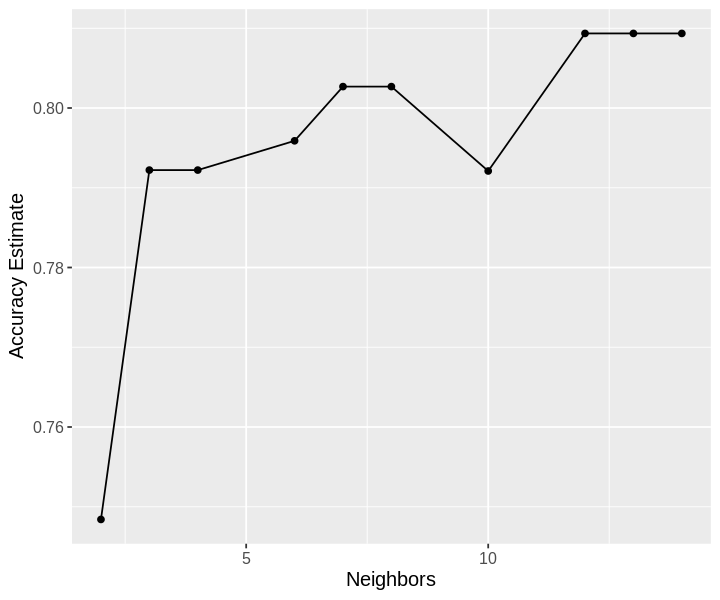

In [13]:
set.seed(999) 
options(repr.plot.height = 5, repr.plot.width = 6)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 12))

accuracy_vs_k

According to above plot, to get the highest possible accuracy, the number of neighbors shoule be around 12-18, in our case, we set it to 13. 

In [14]:
set.seed(999)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
             add_recipe(tennis_recipe) |>
             add_model(knn_spec) |>
            fit(data = tennis_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1911263
Best kernel: rectangular
Best k: 13

In [15]:
set.seed(999) 
tennis_predictions <- predict(knn_fit, tennis_test) |>
bind_cols(tennis_test)
head(tennis_predictions)

tennis_metrics <- tennis_predictions |>
         metrics(truth = rank_top_150, estimate = .pred_class) |>
  filter(.metric == "accuracy")
tennis_metrics

tennis_mat <- tennis_predictions |>
         conf_mat(truth = rank_top_150, estimate = .pred_class)
tennis_mat


.pred_class,Age,Prize,rank_top_150
<fct>,<dbl>,<dbl>,<fct>
top 150,22,1517157,top 150
not top 150,25,122734,not top 150
not top 150,20,74927,top 150
not top 150,28,303458,top 150
not top 150,23,54004,not top 150
not top 150,30,898701,top 150


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8383838


             Truth
Prediction    not top 150 top 150
  not top 150          64      14
  top 150               2      19